# Anomaly Detection in Nifty 50 Index Data

## Import the Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style = 'whitegrid', palette = 'muted')
rcParams['figure.figsize'] = 14,8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.0


## Load and Inspect the Nifty 50 Index Data

In [25]:
df = pd.read_csv('day_interval_NIFTY50.csv',parse_dates = ['date'])
df.head()

,date,close
0,2015-02-04 00:00:00+05:30,8723.70
1,2015-02-05 00:00:00+05:30,8711.70
2,2015-02-06 00:00:00+05:30,8661.05
3,2015-02-09 00:00:00+05:30,8526.35
4,2015-02-10 00:00:00+05:30,8565.55


In [26]:
df.shape

(1360, 2)

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df.date, y = df.close, mode = 'lines', name = 'close'))
fig.update_layout(showlegend = True)
fig.show()

## Data Preprocessing

In [28]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(1088, 2) (272, 2)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Create training and Test Splits

In [30]:
def create_sequences(X,y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
time_steps = 30

X_train, y_train = create_sequences(train[['close']], train.close, time_steps)
X_test, y_test = create_sequences(test[['close']], test.close, time_steps)

In [32]:
X_train.shape

(1058, 30, 1)

## Build an LSTM Autoencoder

In [33]:
timestamps = X_train.shape[1]
num_features = X_train.shape[2]

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape = (timestamps, num_features)),
    Dropout(0.2),
    RepeatVector(timestamps),
    LSTM(128, return_sequences = True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])

model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Train the Autoencoder

In [35]:

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')
#fit model to our trainig data
history=model.fit(
    X_train,y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    shuffle=False


)

Epoch 1/100
30/30 [==============================] - 2s 52ms/step - loss: 0.2380 - val_loss: 0.3806
Epoch 2/100
30/30 [==============================] - 1s 29ms/step - loss: 0.1489 - val_loss: 0.1454
Epoch 3/100
30/30 [==============================] - 1s 31ms/step - loss: 0.1308 - val_loss: 0.2440
Epoch 4/100
30/30 [==============================] - 1s 30ms/step - loss: 0.1425 - val_loss: 0.1353
Epoch 5/100
30/30 [==============================] - 1s 30ms/step - loss: 0.1374 - val_loss: 0.2634
Epoch 6/100
30/30 [==============================] - 1s 31ms/step - loss: 0.1709 - val_loss: 0.1175
Epoch 7/100
30/30 [==============================] - 1s 30ms/step - loss: 0.1347 - val_loss: 0.1051
Epoch 8/100
30/30 [==============================] - 1s 29ms/step - loss: 0.1308 - val_loss: 0.0999
Epoch 9/100
30/30 [==============================] - 1s 29ms/step - loss: 0.1626 - val_loss: 0.1494
Epoch 10/100
30/30 [==============================] - 1s 30ms/step - loss: 0.1359 - val_loss: 0.1147

## Plot Matrics and Evaluate the Model

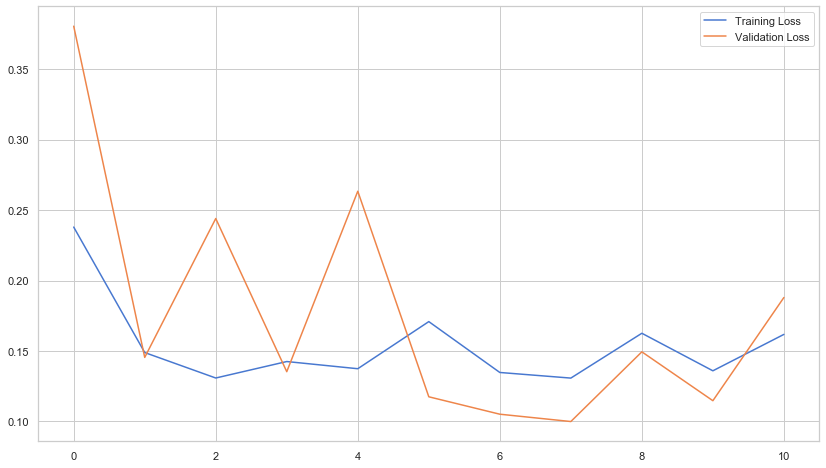

In [36]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend();

In [37]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ['Error'])

In [38]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 10ms/step - loss: 0.2268


0.2267630696296692

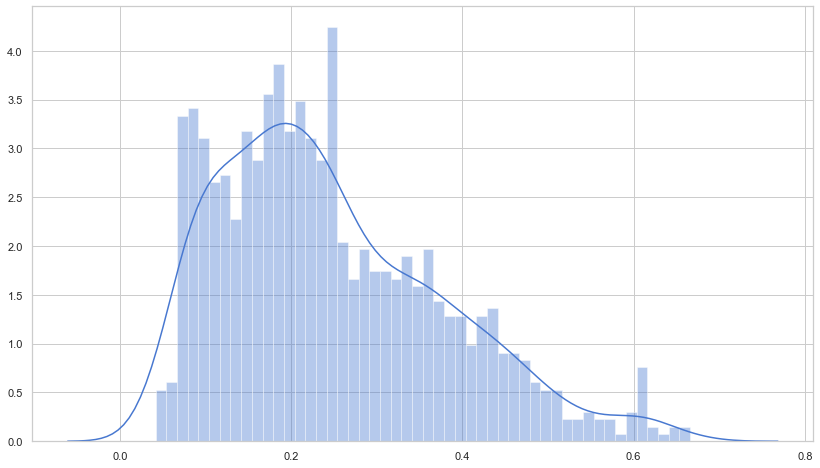

In [39]:
sns.distplot(train_mae_loss, bins = 50, kde = True)

In [62]:
threshold = 0.55

In [63]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

## Detecting Anomalies in Nifty 50 Index Data

In [64]:
# Defining a dataframe to store test set values
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [65]:
test_score_df.head()

,date,close,loss,threshold,anomaly
1118,2019-08-13 00:00:00+05:30,1.141920,0.278756,0.55,False
1119,2019-08-14 00:00:00+05:30,1.221080,0.276493,0.55,False
1120,2019-08-16 00:00:00+05:30,1.235147,0.255531,0.55,False
1121,2019-08-19 00:00:00+05:30,1.239810,0.236142,0.55,False
1122,2019-08-20 00:00:00+05:30,1.211601,0.219602,0.55,False


In [66]:
test_score_df[test_score_df.anomaly == True]

,date,close,loss,threshold,anomaly
1174,2019-11-07 00:00:00+05:30,1.972286,0.565646,0.55,True
1175,2019-11-08 00:00:00+05:30,1.892858,0.586441,0.55,True
1176,2019-11-11 00:00:00+05:30,1.896909,0.551611,0.55,True
1260,2020-03-11 00:00:00+05:30,0.784569,0.660653,0.55,True
1261,2020-03-12 00:00:00+05:30,0.120818,0.783442,0.55,True
1262,2020-03-13 00:00:00+05:30,0.399888,1.105428,0.55,True
1263,2020-03-16 00:00:00+05:30,-0.179427,1.164859,0.55,True
1264,2020-03-17 00:00:00+05:30,-0.355522,1.385517,0.55,True
1265,2020-03-18 00:00:00+05:30,-0.736419,1.551399,0.55,True
1266,2020-03-19 00:00:00+05:30,-0.893403,1.735345,0.55,True


In [67]:
# Plotting Test Set values and adding a threshold line to the graph
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.loss,
                        mode = 'lines', name = 'Test Loss'))

fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.threshold,
                        mode = 'lines', name = 'Threshold'))
fig.update_layout(showlegend = True)
fig.show()

In [68]:
# Storing the anomaly == true values in a new dataframe
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
1174,2019-11-07 00:00:00+05:30,1.972286,0.565646,0.55,True
1175,2019-11-08 00:00:00+05:30,1.892858,0.586441,0.55,True
1176,2019-11-11 00:00:00+05:30,1.896909,0.551611,0.55,True
1260,2020-03-11 00:00:00+05:30,0.784569,0.660653,0.55,True
1261,2020-03-12 00:00:00+05:30,0.120818,0.783442,0.55,True


In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),
                        mode = 'lines', name = 'Close Price'))

fig.add_trace(go.Scatter(x = anomalies.date, y = scaler.inverse_transform(anomalies.close),
                        mode = 'markers', name = 'Anomaly'))
fig.update_layout(showlegend = True)
fig.show()